In [1]:
import os
import json
import ndjson

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

In [2]:
# grid, random and group search without stop:
files=os.listdir("../data/results/test 1")
grid_files = [s for s in files if "grid" in s] # files with results for grid search
random_search_files = [s for s in files if "random" in s] 
group_files = [s for s in files if "group" in s] 

In [3]:
files=os.listdir("../data/results/test 3")
bo_without_groups = [s for s in files if "simple" in s] 
bo_with_groups = [s for s in files if "groups_without_stop" in s] 

In [4]:
# prepare dataframes:

In [5]:
grid_df=pd.DataFrame([])
for file_name in grid_files:
    df = pd.read_csv("../data/results/test 1/"+file_name, usecols = ['experiment_name',
                                                                     'mean_test_score'])
    
    df['iter_num']=1
    df.loc[df['experiment_name']!='default params', 
           'iter_num'] = range(1, df.loc[df['experiment_name']!='default params'].shape[0]+1)
    
    grid_df = pd.concat([grid_df, df], sort=False)
    
random_df = pd.DataFrame([])
for file_name in random_search_files:
    file_df = pd.read_csv("../data/results/test 1/" + file_name, 
                              usecols = ['experiment_name', 'mean_test_score',
                                         'run_number'])
    file_df['iter_num'] = range(1, file_df.shape[0]+1) 
    random_df = pd.concat([random_df, file_df], sort = False)
    
group_df = pd.DataFrame([])
for file_name in group_files:
    file_df = pd.read_csv("../data/results/test 1/" + file_name, 
                              usecols = ['experiment_name', 'mean_test_score',
                                         'run_number'])
    file_df['iter_num'] = range(1, file_df.shape[0]+1) 
    group_df = pd.concat([group_df, file_df], sort = False)

In [6]:
# for bayes opt

In [27]:
def get_df_from_files(files_names):
    res_df = pd.DataFrame([])
    time_df = pd.DataFrame([])
    for file in files_names:
        with open ("../data/results/test 3/"+file, "r") as read_file:
            file_df = ndjson.load(read_file)
            file_df = pd.DataFrame(file_df)
            time_df_part = file_df['datetime']
            time_df_part = pd.DataFrame(
                ndjson.loads(ndjson.dumps(time_df_part.values))
            )
            file_df = file_df['target']
            file_df_new = pd.DataFrame([])
            file_df_new['iter_num'] = range(1, file_df.shape[0]+1) 
            file = file.replace(r'_concat','')
            file_df_new['run_number'] = int(file.split(".")[0].split("_")[-1])
            file_df = pd.concat([file_df, file_df_new], sort=False, axis=1)
            res_df = pd.concat([res_df, file_df], sort = False)
            time_df = pd.concat([time_df, time_df_part], sort = False)
    return res_df, time_df

bo_without_groups_df, bo_without_groups_time_df = get_df_from_files(bo_without_groups)
bo_with_groups_df, bo_with_groups_time_df = get_df_from_files(bo_with_groups)



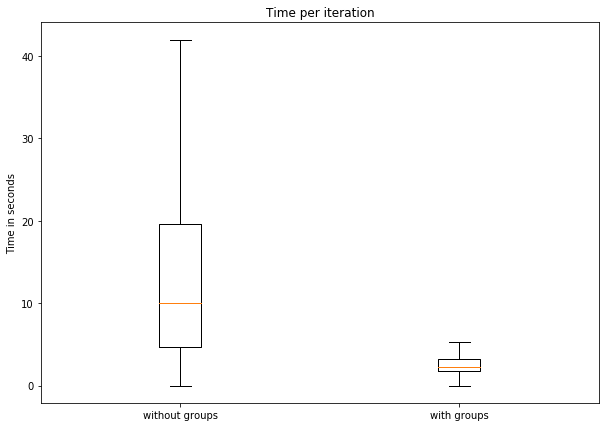

In [29]:
fig, ax = plt.subplots(figsize=(10,7))
ax.set_title('Time per iteration')
ax.boxplot([bo_without_groups_time_df['delta'], 
            bo_with_groups_time_df['delta']],
          showfliers=False,
          labels=['without groups', 'with groups'])

ax.set_ylabel("Time in seconds")
plt.savefig("../graphs/test 3/time_per_iteration.jpg")
plt.show()

In [36]:
last_bo_time_without_groups = bo_without_groups_time_df.loc[728]
last_bo_time_with_groups = bo_with_groups_time_df.loc[728]

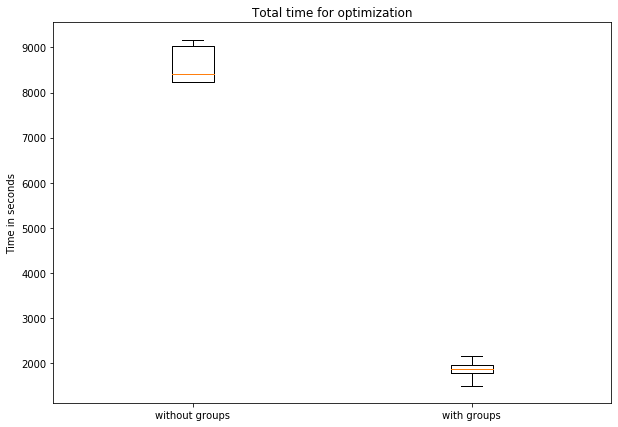

In [43]:
fig, ax = plt.subplots(figsize=(10,7))
ax.set_title('Total time for optimization')

ax.boxplot([last_bo_time_without_groups['elapsed'], 
            last_bo_time_with_groups['elapsed']],
          showfliers=False,
          labels=['without groups', 'with groups'])

ax.set_ylabel("Time in seconds")
plt.savefig("../graphs/test 3/total_time.jpg")
plt.show()

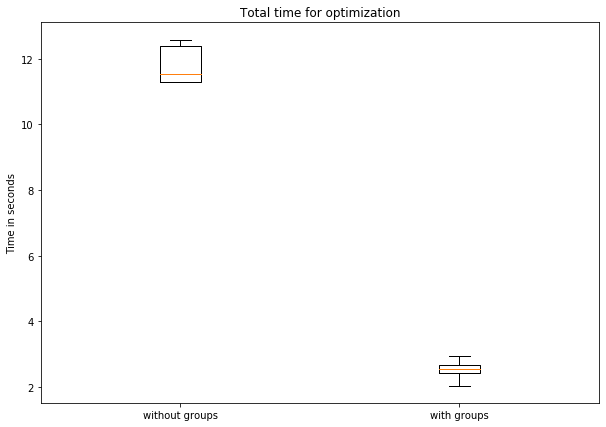

In [44]:
fig, ax = plt.subplots(figsize=(10,7))
ax.set_title('Total time for optimization')

ax.boxplot([last_bo_time_without_groups['elapsed']/729, 
            last_bo_time_with_groups['elapsed']/729],
          showfliers=False,
          labels=['without groups', 'with groups'])

ax.set_ylabel("Time in seconds")
plt.savefig("../graphs/test 3/average_time.jpg")
plt.show()

In [8]:
bo_without_groups_df = bo_without_groups_df.rename(columns={'target': 'mean_test_score'})
bo_with_groups_df = bo_with_groups_df.rename(columns={'target': 'mean_test_score'})

In [9]:
# get best scores and iter num
def get_best_info(df, name):
    grpby = df.groupby('run_number')
    best_scores = grpby['mean_test_score'].max().reset_index()
    best_info = df.merge(best_scores)
    best_info['experiment_name']=name
    return best_info
    
best_info = pd.DataFrame([])

all_dfs = [bo_without_groups_df, bo_with_groups_df, 
           random_df, group_df]
names = ['bayes_opt_without_groups', 'bayes_opt_with_groups', 
         'random_search', 'random_search_with_groups']
for df, name in zip(all_dfs, names):
    best_info = pd.concat([best_info, get_best_info(df, name)], sort=False)
    for i in df.run_number.unique():    
        df.loc[df.run_number==i, "mean_test_score"] = (
            df.loc[df.run_number==i, "mean_test_score"].copy().cummax()
        )


In [10]:
best_grpby = best_info.groupby(['experiment_name']).agg(np.mean, np.std)
best_grpby.mean()

Series([], dtype: float64)

In [11]:
best_grpby = best_info.groupby(['experiment_name'])
means = best_grpby.mean()
mins = best_grpby.min()
maxs = best_grpby.max()

In [25]:
stds = best_grpby.std()

In [28]:
stds

,mean_test_score,iter_num,run_number
experiment_name,,,
bayes_opt_with_groups,0.002789,77.048974,3.02765
bayes_opt_without_groups,0.001979,166.200715,3.02765
random_search,0.001628,217.234870,3.02765
random_search_with_groups,0.001654,58.173018,3.02765


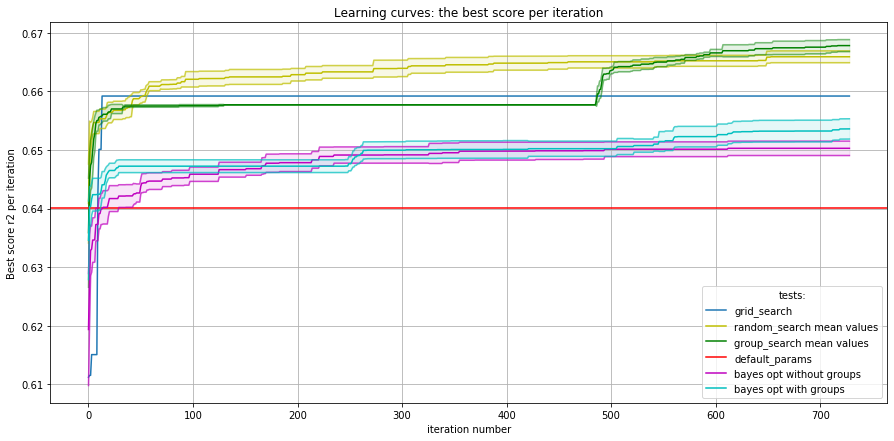

In [21]:
# Data with stop criterion
# stop if the cumulative score hasn't grown in "stop_iter_num" iterations
# GRID_SEARCH
#get best scores per itration for grid_search performance:
grid_perf=grid_df.loc[grid_df['experiment_name']!='default params',
                      'mean_test_score'].cummax()


## RANDOM_SEARCH
# get best scores per itration for each random_search performance:
# random_df_stopped
    
#get mean and confidence interval value for random_search performance on iteration:    

z = 1.96 # for 95% conf interval (coefficient)
# z = 1.64 # for 90% conf interval

n=10
random_std=random_df.groupby(by="iter_num")['mean_test_score'].std() #std
random_std=(random_std*z)/np.sqrt(n) #confidence interval value 
random_mean=random_df.groupby(by="iter_num")['mean_test_score'].mean() #mean


## GROUP_SEARCH
#get best scores per itration for each group_search performance (same computations):
group_std=group_df.groupby(by="iter_num")['mean_test_score'].std()
group_std=(group_std*z)/np.sqrt(n) 
group_std=group_std.fillna(0)
group_mean=group_df.groupby(by="iter_num")['mean_test_score'].mean()

## DEFAULT performance
default_perf=grid_df.loc[grid_df['experiment_name']=='default params', 'mean_test_score']

## BAYES WITHOUT GROUPS
bo_std=bo_without_groups_df.groupby(by="iter_num")['mean_test_score'].std()
bo_std=(bo_std*z)/np.sqrt(n) 
bo_std=bo_std.fillna(0)
bo_mean=bo_without_groups_df.groupby(by="iter_num")['mean_test_score'].mean()


## BAYES WITH GROUPS
bo_groups_std=bo_with_groups_df.groupby(by="iter_num")['mean_test_score'].std()
bo_groups_std=(bo_groups_std*z)/np.sqrt(n) 
bo_groups_std=bo_groups_std.fillna(0)
bo_groups_mean=bo_with_groups_df.groupby(by="iter_num")['mean_test_score'].mean()

## PLOT
plt.figure(figsize=(15,7))
plt.grid()

#grid plot:
x=list(range(0, grid_perf.shape[0]))
plt.plot(x, grid_perf, label="grid_search")

#conf for random:
x=list(range(0, random_mean.shape[0]))
plt.plot(x, random_mean, color="y", label="random_search mean values")
lower_random=random_mean - random_std
upper_random=random_mean + random_std
plt.plot(x, lower_random, alpha=0.7, color="y")
plt.plot(x, upper_random, alpha=0.7, color="y")
plt.fill_between(x, lower_random, upper_random, alpha=0.1, color="y") 

#conf for group:
plt.plot(x, group_mean, color="green", label="group_search mean values")
lower_group=group_mean - group_std
upper_group=group_mean + group_std
plt.plot(x, lower_group, alpha=0.5, color="green")
plt.plot(x, upper_group, alpha=0.5, color="green")
plt.fill_between(x, lower_group, upper_group, alpha=0.1, color="green")

#line for default values
plt.axhline(default_perf.values, label="default_params", color='r')

#conf for bayes opt without groups:
plt.plot(x, bo_mean, color="m", label="bayes opt without groups")
lower_bo=bo_mean - bo_std
upper_bo=bo_mean + bo_std
plt.plot(x, lower_bo, alpha=0.7, color="m")
plt.plot(x, upper_bo, alpha=0.7, color="m")
plt.fill_between(x, lower_bo, upper_bo, alpha=0.1, color="m") 

#conf for bayes opt wit groups:
plt.plot(x, bo_groups_mean, color="c", label="bayes opt with groups")
lower_bo_groups=bo_groups_mean - bo_groups_std
upper_bo_groups=bo_groups_mean + bo_groups_std
plt.plot(x, lower_bo_groups, alpha=0.7, color="c")
plt.plot(x, upper_bo_groups, alpha=0.7, color="c")
plt.fill_between(x, lower_bo_groups, upper_bo_groups, alpha=0.1, color="c") 


plt.legend(title='tests:')
plt.title("Learning curves: the best score per iteration")
plt.ylabel("Best score r2 per iteration")
plt.xlabel("iteration number")
plt.savefig("../graphs/test 3/scores_without_stop.jpg")
plt.show()

In [23]:
upper_bo[-5:]

iter_num
725    0.651497
726    0.651497
727    0.651497
728    0.651497
729    0.651497
Name: mean_test_score, dtype: float64

In [24]:
lower_bo_groups[-5:]

iter_num
725    0.651841
726    0.651841
727    0.651853
728    0.651853
729    0.651853
Name: mean_test_score, dtype: float64

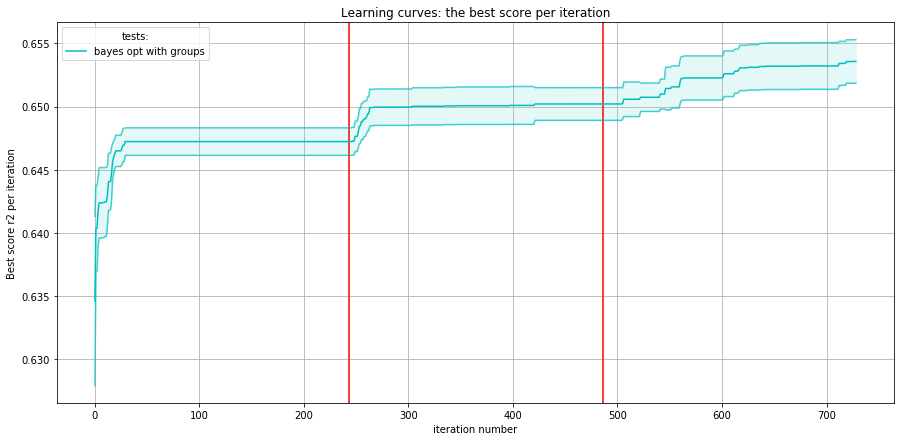

In [39]:
## PLOT
plt.figure(figsize=(15,7))
plt.grid()

#line for default values
plt.axvline(243, color='r')
plt.axvline(243*2, color='r')

#conf for bayes opt wit groups:
plt.plot(x, bo_groups_mean, color="c", label="bayes opt with groups")
lower_bo_groups=bo_groups_mean - bo_groups_std
upper_bo_groups=bo_groups_mean + bo_groups_std
plt.plot(x, lower_bo_groups, alpha=0.7, color="c")
plt.plot(x, upper_bo_groups, alpha=0.7, color="c")
plt.fill_between(x, lower_bo_groups, upper_bo_groups, alpha=0.1, color="c") 


plt.legend(title='tests:')
plt.title("Learning curves: the best score per iteration")
plt.ylabel("Best score r2 per iteration")
plt.xlabel("iteration number")
plt.savefig("../graphs/test 3/scores_bayes_without_stop.jpg")
plt.show()